In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [4]:

import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)


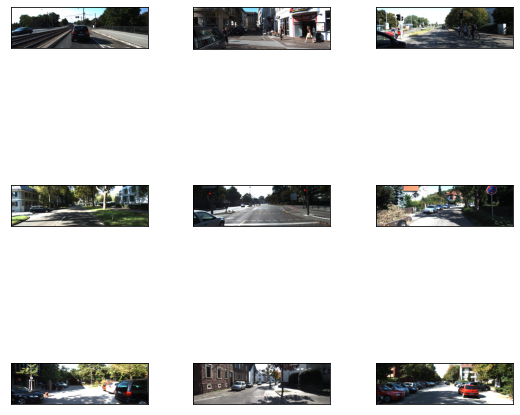

In [5]:
fig = tfds.show_examples(ds_train, ds_info)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

In [7]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 1.73,  2.65, -1.56,  2.05, -1.94], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.3632    , 0.3308132 , 0.65037334, 0.41966185],
       [0.42693335, 0.72769725, 0.49744   , 0.786095  ],
       [0.37869334, 0.4491546 , 0.5291733 , 0.49472624],
       [0.45568   , 0.192343  , 0.5199467 , 0.23527375],
       [0.41853333, 0.67201287, 0.51794666, 0.6890741 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[2.84, 2.22, 6.86],
       [1.68, 1.39, 4.26],
       [1.62, 1.63, 4.5 ],
       [1.46, 1.31, 4.15],
       [1.64, 0.34, 1.58]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ -4.28,   1.78,  22.62],
       [ 22.13,   2.76,  48.48],
       [ -0.78,   1.76,  23.22],
       [-22.  ,   1.93,  46.19],
       [ 10.62,   2.01,  32.69]], dtype=float32)>, 'occ

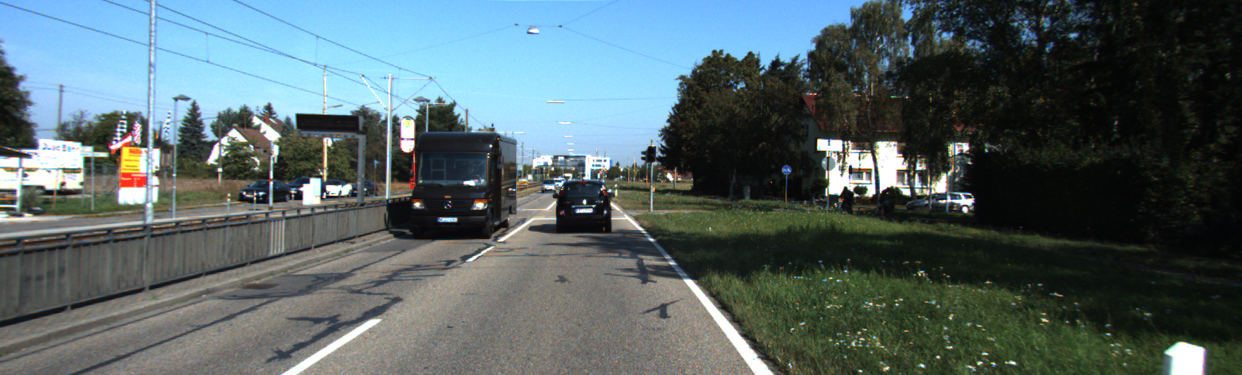

In [8]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

1242 375
(5, 4)
[[410.87    238.8     521.22003 131.11   ]
 [903.8     214.9     976.33    188.45999]
 [557.85    232.98999 614.45    176.56001]
 [238.89    204.12    292.21    180.01999]
 [834.63995 218.05    855.83    180.77   ]]
[410.87    238.8     521.22003 131.11   ]
[903.8     214.9     976.33    188.45999]
[557.85    232.98999 614.45    176.56001]
[238.89    204.12    292.21    180.01999]
[834.63995 218.05    855.83    180.77   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F36C4795F90>


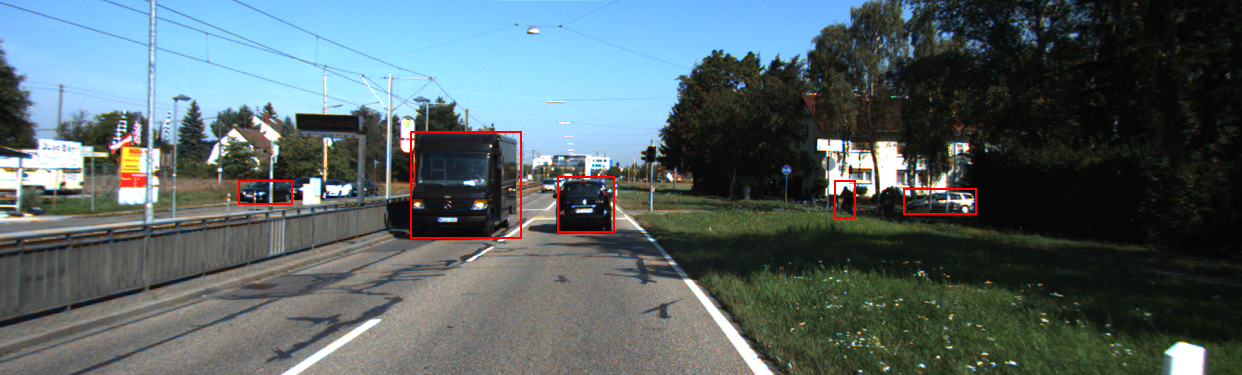

In [9]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # [[YOUR CODE]]
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    # [[YOUR CODE]]
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [10]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [10:55<00:00,  9.68it/s]


In [11]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:17<00:00,  9.12it/s]


In [12]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

In [13]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2020-10-22 17:13:03.016315: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 17:13:04.146495: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-22 17:13:04.151054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-22 17:13:04.151672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-22 17:13:04.151687: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 17:13:04.153359: I tensorflow/stream_executor/platform

In [14]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-10-22 18:03:06.452736: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 18:03:07.709247: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-22 18:03:07.714210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-22 18:03:07.714715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-22 18:03:07.714729: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 18:03:07.716656: I tensorflow/stream_executor/platform

In [53]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)


model_path = os.getenv('HOME')+'/workplace/GD6/snapshots/resnet50_csv_50_infer.h5'
#model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[595.1893  176.40659 627.9615  207.02039]
[595 176 627 207] 0.7001846 0
[189.76558 134.19707 348.46344 227.3607 ]
[189 134 348 227] 0.28096193 0
[606.13776 173.52821 632.82263 203.63606]


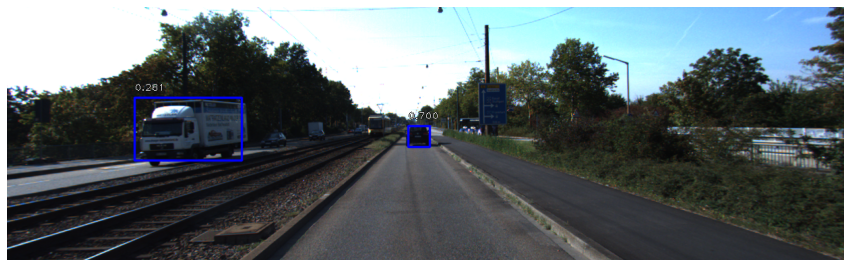

In [61]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.25:
                break
            b = box.astype(int)
            print(b, score, label)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[771.5215  149.21188 846.5533  315.20288]
[771 149 846 315] 0.79385585 1
[764.6313  147.1393  853.69604 300.07498]


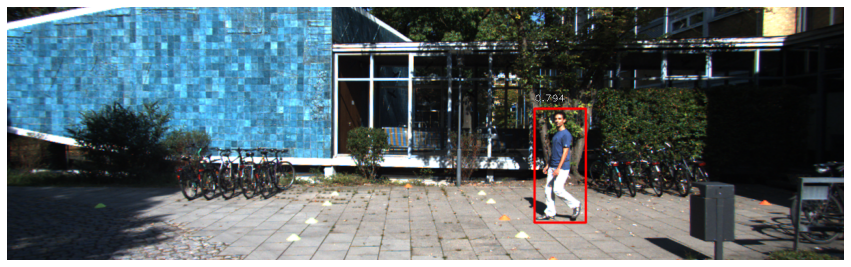

In [62]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

[ 755.87726  185.33107 1017.2892   365.49042]
[ 755  185 1017  365] 0.34296656 0
[ 728.3099    54.89458 1078.1234   369.17026]
[ 728   54 1078  369] 0.3363575 0
[ 52.609306 168.6559   367.82465  336.1702  ]


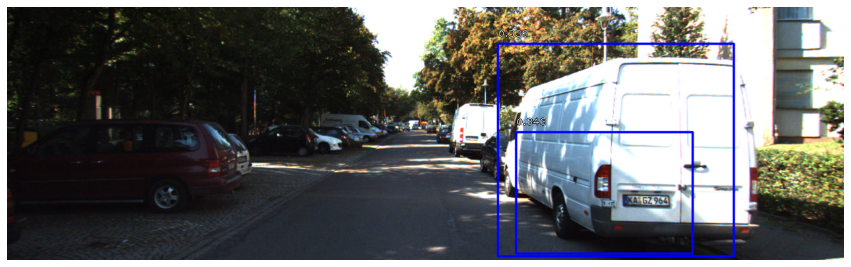

In [63]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_4.png'
inference_on_image(model, img_path=img_path)

### 프로젝트

In [64]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'


def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
    
    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    w = 0
    h = 0

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.1:
                break
        b = box.astype(int)
        # 차량 width, height
        w = b[2]-b[0]
        h = b[3]-b[1]
        
    
        #   조건은 다음과 같습니다.
        #    사람이 한 명 이상 있는 경우
        #    차량의 크기(width or height)가 300px이상인 경우
        
        if w >= size_limit or h >= size_limit or label==1:
            print(f'width : {w}, height : {h}, score : {score}, label : stop')
            return 'Stop'
        else:
            print(f'width : {w}, height : {h}, score : {score}, label : go')
            return 'Go'

print(self_drive_assist(img_path))  

width : 75, height : 166, score : 0.7938558459281921, label : stop
Stop


In [65]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

width : 75, height : 166, score : 0.7938558459281921, label : stop
width : 86, height : 166, score : 0.6711340546607971, label : stop
width : 307, height : 169, score : 0.6925643682479858, label : stop
width : 262, height : 180, score : 0.34296655654907227, label : go
width : 366, height : 198, score : 0.48016980290412903, label : stop
width : 32, height : 31, score : 0.7001845836639404, label : go
width : 40, height : 38, score : 0.7981431484222412, label : go
width : 81, height : 31, score : 0.28232526779174805, label : go
width : 93, height : 81, score : 0.498919278383255, label : go
width : 179, height : 134, score : 0.5070548057556152, label : go
90점입니다.


In [66]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_4.png'
print(self_drive_assist(img_path)) 

width : 262, height : 180, score : 0.34296655654907227, label : go
Go


### 4번 stop 인대 아무리 해도 stop 해야 하는대...차가 이상하게 잡히네요